In [290]:
import PyPDF2
import stanfordnlp
import pickle
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import *
from tqdm import tqdm
import re
import random
import math
import matplotlib.pyplot as plt

In [291]:
_ = torch.manual_seed(0)

In [292]:
class TransformerSentence():
        
    def __init__(self, sentence_str, 
                 model=BertModel.from_pretrained('scibert-scivocab-uncased'), 
                 tokenizer=BertTokenizer.from_pretrained('scibert-scivocab-uncased')):
        
        self.raw_string = sentence_str
        self.model = model
        self.tokenizer = tokenizer
        self.summary = {}

    def write_summary(self, input_tokens=None, 
                      hidden_states=None, 
                      hidden_attentions=None,
                      print_tokens=True):
        
        if (input_tokens or hidden_states or hidden_attentions) is None:
            input_tokens, hidden_states, hidden_attentions = self.forward()
            
        if print_tokens:
            print('Sentence Tokenization: ', input_tokens)
            
        # write summary into the object
        self.summary['input_tokens'] = input_tokens
        self.summary['states'] = hidden_states #[hidden_states[i, :, :] for i in range(len(input_tokens))]
        self.summary['attentions'] = hidden_attentions
        self.summary['token_embeddings'] = {input_token: hidden_states[:, i, :] 
                                      for i, input_token in enumerate(input_tokens)}
        
    def forward(self):
        encoded_inputs_dict = self.tokenizer.encode_plus(self.raw_string)
        input_ids = encoded_inputs_dict['input_ids']
        input_tensor = torch.tensor([input_ids])
        input_tokens = [self.tokenizer.decode(input_ids[j]).replace(' ', '') 
                        for j in range(len(input_ids))]
        
        final_attention, final_state, hidden_states_tup, hidden_attentions_tup = self.model(input_tensor)
        
        # stacking states and attentions along the first dimention (which corresponds to the batch when necessary)
        hidden_attentions = torch.cat(hidden_attentions_tup, dim=0) # 'layers', 'heads', 'queries', 'keys'
        hidden_states = torch.cat(hidden_states_tup, dim=0) # 'layers', 'tokens', 'embeddings' 
        
        return input_tokens, hidden_states.detach(), hidden_attentions.detach()
    
    
    def attention_from_tokens(self, token1, token2, display=True):
        input_tokens = self.summary['input_tokens']
        
        if (token1 and token2) not in input_tokens:
            raise ValueError('One or both of the tokens introduced are not in the sentence!')
            
        idx1, idx2 = input_tokens.index(token1), input_tokens.index(token2)
        attention = self.summary['attentions'][:, :, idx1, idx2].numpy()
        if display:
            TransformerSentence.display_attention(attention, title=(token1, token2))
        return attention
    
    
    def attention_from_idx(self, i, j, display=True):
        attention = self.summary['attentions'][:, :, i, j].numpy()
        if display:
            TransformerSentence.display_attention(attention, title=f'Token idx: {(i, j)}')
        return attention
    
    
    
    def save(self, name, path='.'):
        with open(os.path.join(path, name), 'wb') as file:
            pickle.dump(self, file)
    
    @staticmethod
    def visualize_embedding(embedding, title=None, vmax=None, vmin=None):
        if (vmax or vmin) is None:
            vmax = max(embedding)
            vmin = min(embedding)
            
        N = embedding.size()[0]
        h = math.ceil(math.sqrt(N))
        # N = a*b where abs(a-b) is minimum
        while (N % h != 0):
            h -= 1
        w = int(N / h)
        visualization = embedding.reshape((h, w)).numpy()
        fig, ax = plt.subplots()
        im = ax.imshow(visualization, vmax=vmax, vmin=vmin)
        if title is not None:
            ax.set_title(title)
        plt.show()
    
    @staticmethod
    def display_attention(attention, title=None):
        fig, ax = plt.subplots()
        im = ax.imshow(attention, vmin=0., vmax=1.)
        if title is not None:
            ax.set_title(title)
        ax.set_xlabel('HEADS')
        ax.set_ylabel('LAYERS')
        plt.show()
    
    @staticmethod
    def load(name, path='.'):
        with open(os.path.join(path, name), 'rb') as file:
            SentenceObject = pickle.load(file)
        return SentenceObject

In [293]:
# Preloading models (this is the most time cost)
BertBaseModel = BertModel.from_pretrained('bert-base-uncased')
BertBaseTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BertLargeModel = BertModel.from_pretrained('bert-large-uncased')
BertLargeTokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
SciBertModel = BertModel.from_pretrained('scibert-scivocab-uncased')
SciBertTokenizer = BertTokenizer.from_pretrained('scibert-scivocab-uncased')

In [236]:
raw_sentence = "Computer Vision: What is the difference between local descriptors and global descriptors"

scibert_sentence = TransformerSentence(raw_sentence,
                                       model=SciBertModel,
                                       tokenizer=SciBertTokenizer)
bert_sentence = TransformerSentence(raw_sentence,
                                    model=BertBaseModel,
                                    tokenizer=BertBaseTokenizer)
bert_large_sentence = TransformerSentence(raw_sentence,
                                          model=BertLargeModel,
                                          tokenizer=BertLargeTokenizer)

In [237]:
scibert_sentence.write_summary(print_tokens=False)
bert_sentence.write_summary(print_tokens=False)
bert_large_sentence.write_summary(print_tokens=False)

In [ ]:
e1i =  scibert_sentence.summary['token_embeddings']['computer'][0,:]
e1f =  scibert_sentence.summary['token_embeddings']['computer'][-1,:]
e2i =  scibert_sentence.summary['token_embeddings']['vision'][0,:]
e2f =  scibert_sentence.summary['token_embeddings']['vision'][-1,:]


In [ ]:
_ = scibert_sentence.attention_from_tokens('what', 'difference', display=True)
_ = bert_sentence.attention_from_tokens('what', 'difference', display=True)

In [294]:
# Read input sequences from .txt file and put them in a list
with open("../datasets/quora_questions.txt") as f:
    text = f.read()
sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
try:
    sentences.remove('') # remove possible empty strings
except:
    None

In [340]:
scibert_sentences = []
for raw_sentence in tqdm(sentences):
    SentenceObj = TransformerSentence(raw_sentence,
                                      model=BertBaseModel,
                                      tokenizer=BertBaseTokenizer)
    SentenceObj.write_summary(print_tokens=False)
    scibert_sentences.append(SentenceObj)

100%|██████████| 301/301 [00:47<00:00,  6.29it/s]


In [341]:
for i, sentence in enumerate(scibert_sentences):
    print(i, sentence.raw_string)

0 Are convolutional neural networks useful for tasks other than image classification?
1 Are non-causal temporal convolutions the equivalence of Bi-LSTM?
2 Are there any techniques, other than RNN/LSTM, to handle time series data?
3 Bayesian Inference: What is a Dirichlet process in layman's terms?
4 Can an objective account of statistical inference be based on frequentist methods and Bayesian methods?
5 Can Bayesian Network be combined with Deep Learning and/or reinforcement Learning to figure out causation?
6 Can deep neural networks learn the minimum function?
7 Can facial recognition tools be fooled?
8 Can recurrent neural networks with LSTM be used for time series prediction?
9 Can RNN be used for time series dynamic modelling?
10 If yes, how?
11 Can you explain the HMM algorithm?
12 Classification (machine learning): When should I use a K-NN classifier over a Naive Bayes classifier?
13 Computer Vision: What is the difference between HOG and SIFT feature descriptor?
14 Computer Vis

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Library/Frameworks/Python.f

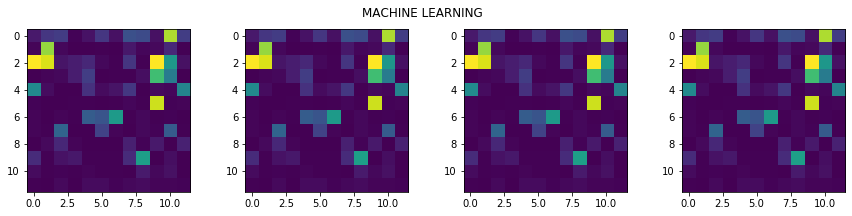

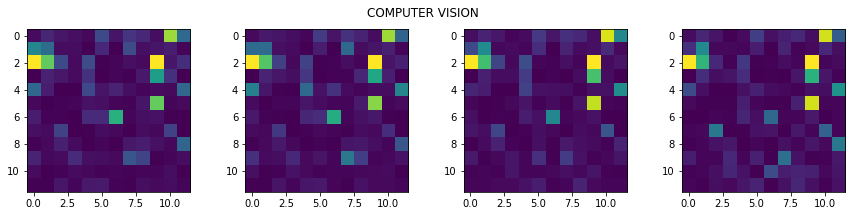

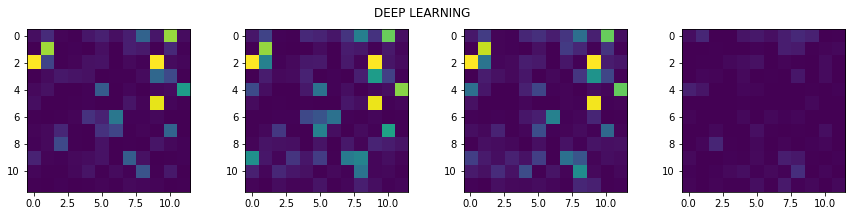

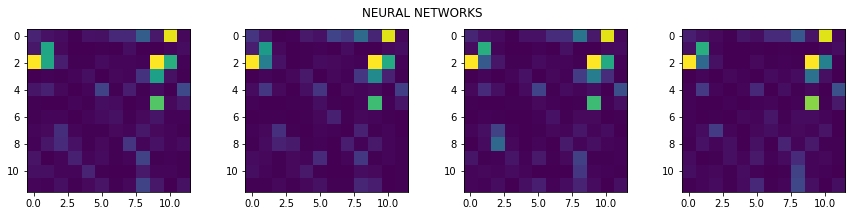

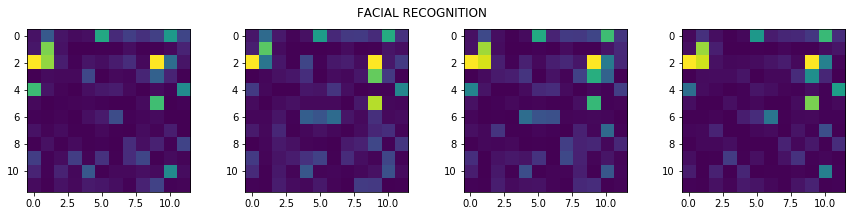

In [342]:
scibert_sentences[0].summary['states'][0, :, :].size()

# machine learning
ml1 = scibert_sentences[12]
ml2 = scibert_sentences[16]
ml3 = scibert_sentences[17]
ml4 = scibert_sentences[19]
list_ml = [ml1, ml2 ,ml3, ml4]
# computer vision     
cv1 = scibert_sentences[13]
cv2 = scibert_sentences[14]
cv3 = scibert_sentences[17]
cv4 = scibert_sentences[91]
list_cv = [cv1, cv2, cv3, cv4]
# deep learning    
dl1 = scibert_sentences[5]
dl2 = scibert_sentences[22]
dl3 = scibert_sentences[26]
dl4 = scibert_sentences[75]
list_dl = [dl1, dl2, dl3, dl4]
# neural networks
nns1 = scibert_sentences[0]
nns2 = scibert_sentences[6]
nns3 = scibert_sentences[8]
nns4 = scibert_sentences[85]
nn5 = scibert_sentences[66]
nnf6 = scibert_sentences[41]
nnf7 = scibert_sentences[53]
list_nns = [nns1, nns2, nns3, nns4]
# facial recognition
fr1 = scibert_sentences[7]
fr2 = scibert_sentences[47]
fr3 = scibert_sentences[182]
fr4 = scibert_sentences[260]
list_fr = [fr1, fr2, fr3, fr4]
# 

size = (15, 3)

fig, axs = plt.subplots(1, 4, figsize=size)
fig.suptitle('MACHINE LEARNING')
for i, ml in enumerate(list_ml):
    a = ml1.attention_from_tokens('machine', 'learning', display=False)
    axs[i].imshow(a, vmax=1., vmin=0.)
fig.show()

fig, axs = plt.subplots(1, 4, figsize=size)
fig.suptitle('COMPUTER VISION')
for i, cv in enumerate(list_cv):
    a = cv.attention_from_tokens('computer', 'vision', display=False)
    axs[i].imshow(a, vmax=1., vmin=0.)
fig.show()

fig, axs = plt.subplots(1, 4, figsize=size)
fig.suptitle('DEEP LEARNING')
for i, dl in enumerate(list_dl):
    a = dl.attention_from_tokens('deep', 'learning', display=False)
    axs[i].imshow(a, vmax=1., vmin=0.)
fig.show()

fig, axs = plt.subplots(1, 4, figsize=size)
fig.suptitle('NEURAL NETWORKS')
for i, nns in enumerate(list_nns):
    a = nns.attention_from_tokens('neural', 'networks', display=False)
    axs[i].imshow(a, vmax=1., vmin=0.)
fig.show()


fig, axs = plt.subplots(1, 4, figsize=size)
fig.suptitle('FACIAL RECOGNITION')
for i, fr in enumerate(list_fr):
    a = fr.attention_from_tokens('facial', 'recognition', display=False)
    axs[i].imshow(a, vmax=1., vmin=0.)
fig.show()

In [343]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-08) # similarity func.
sentence = scibert_sentences[23]
print(sentence.raw_string)
print(sentence.summary['input_tokens'])

How are linear regression and gradient descent related, is gradient descent a type of linear regression, and is it similar to ordinary least squares (OLS) and generalized least squares (GLS)?
['[CLS]', 'how', 'are', 'linear', 'regression', 'and', 'gradient', 'descent', 'related', ',', 'is', 'gradient', 'descent', 'a', 'type', 'of', 'linear', 'regression', ',', 'and', 'is', 'it', 'similar', 'to', 'ordinary', 'least', 'squares', '(', 'ol', '##s', ')', 'and', 'generalized', 'least', 'squares', '(', 'g', '##ls', ')', '?', '[SEP]']


In [349]:
distance_evolution = {}
for token1 in sentence.summary['input_tokens']:
    for token2 in sentence.summary['input_tokens']:
        embs1 = sentence.summary['token_embeddings'][token1]#.clamp(-2, 2)
        embs2 = sentence.summary['token_embeddings'][token2]#.clamp(-2, 2)
        distance_evolution[(token1, token2)] = list(cos(embs1, embs2))

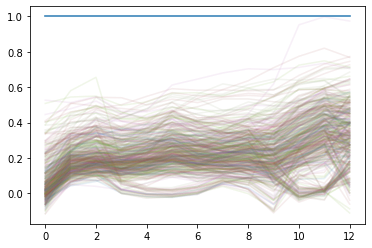

In [350]:
for key, d in distance_evolution.items():
    plt.plot(d, alpha=0.05)

tensor(1.9253) tensor(-1.9755)


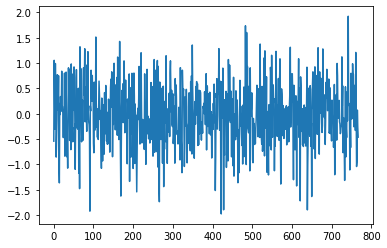

tensor(2.5013) tensor(-2.1905)


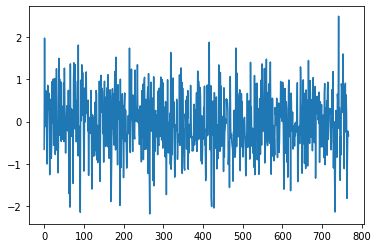

tensor(2.7683) tensor(-3.1338)


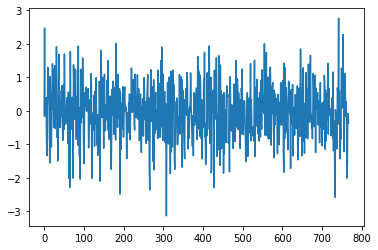

tensor(2.8385) tensor(-3.5272)


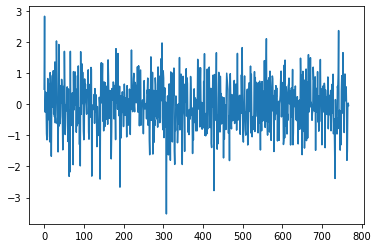

tensor(2.4065) tensor(-3.9035)


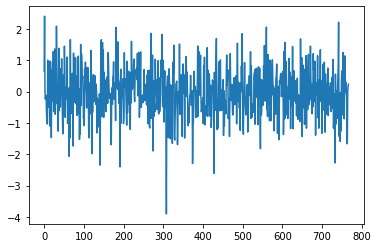

tensor(2.4719) tensor(-5.0308)


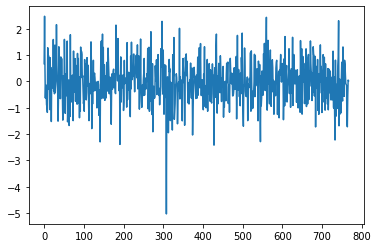

tensor(2.6556) tensor(-4.5518)


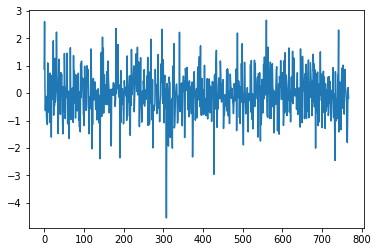

tensor(2.6616) tensor(-3.3848)


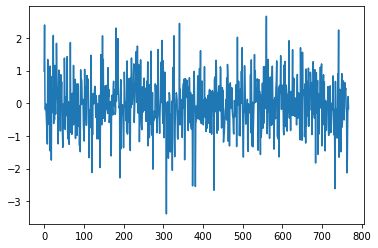

tensor(2.2504) tensor(-3.4841)


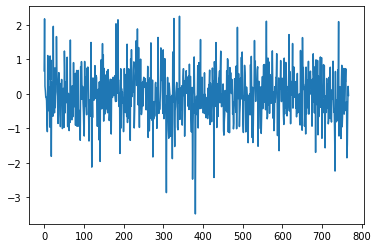

tensor(2.3973) tensor(-3.5969)


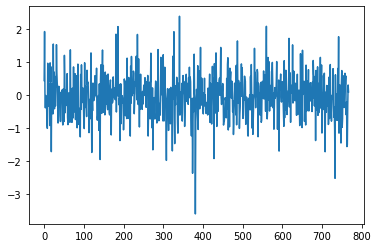

tensor(2.7134) tensor(-2.8479)


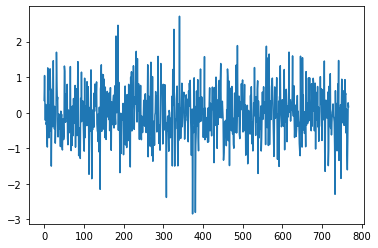

tensor(2.5206) tensor(-3.6580)


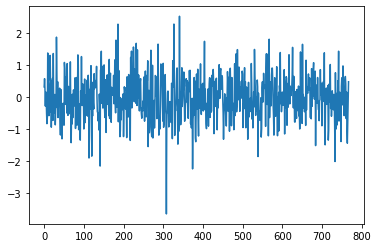

tensor(1.9958) tensor(-1.8850)


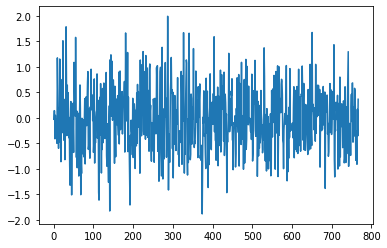

In [347]:
#### SEE EMBEDDING ACROSS LAYERS ####
token = 'linear'
for i in range(13):
    embedding = sentence.summary['token_embeddings'][token][i, :]#.clamp(-2, 2)
    print(max(embedding), min(embedding))
    plt.plot(embedding, alpha=1)
    plt.show()
    #sentence.visualize_embedding(embedding)